In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re
import os

## read data

In [2]:
results_dir = "cargo_results"

pat0 = re.compile("p[1234]_s(?P<algo>\d\d?)\.txt$")
pat1 = re.compile("Problem (?P<problem>\d) using (?P<algorithm>[a-z_]+)"
                  "(?: with (?P<heuristic>[a-z_]+))?\.")
pat2 = re.compile("\s+(?P<actions>[0-9]+)"
                  "\s+(?P<expansions>[0-9]+)\s+"
                  "(?P<goal_tests>[0-9]+)\s+"
                  "(?P<new_nodes>[0-9]+)")
pat3 = re.compile("length: (?P<plan_length>\d+)\s+Time elapsed in seconds: (?P<time>[0-9.]+)")

converters = {
    'actions': int,
    'algo': int,
    'expansions': int,
    'goal_tests': int,
    'new_nodes': int,
    'plan_length': int,
    'problem': int,
    'time': float,
    'heuristic': lambda x: x if x else ''
}

def extract(filepath):
    with open(filepath) as fp:
        s = fp.read()
    m = pat0.search(filepath)
    record = m.groupdict()
    for pat in (pat1, pat2, pat3):
        m = pat.search(s)
        record.update(m.groupdict())
    for field, func in converters.items():
        record[field] = func(record[field])
    return record

filenames = os.listdir(results_dir)
filepaths = [os.path.join(results_dir, filename) for filename in filenames]
records = [extract(filepath) for filepath in filepaths]
df = pd.DataFrame(records)

df.sort_values(["problem", "algo"], inplace=True)
df.head()

,actions,algo,algorithm,expansions,goal_tests,heuristic,new_nodes,plan_length,problem,time
0,20,1,breadth_first_search,43,56,,178,6,1,0.054103
3,20,2,depth_first_graph_search,21,22,,84,20,1,0.024324
4,20,3,uniform_cost_search,60,62,,240,6,1,0.079008
5,20,4,greedy_best_first_graph_search,7,9,h_unmet_goals,29,6,1,0.013098
6,20,5,greedy_best_first_graph_search,6,8,h_pg_levelsum,28,6,1,1.015349


### plotting function

In [3]:
alg_heur = sorted(set([tuple(x) for x in df[['algorithm', 'heuristic']].values]))

algs = df.algorithm.unique()
colors = {
    'breadth_first_search': 'tab:red',
    'depth_first_graph_search': 'tab:orange',
    'uniform_cost_search': 'tab:purple',
    'greedy_best_first_graph_search': 'tab:blue',
    'astar_search': 'tab:green'
}

heurs = df.heuristic.unique()
markers = {
    "": "o",
    "h_unmet_goals": "D",
    "h_pg_levelsum": "v",
    "h_pg_maxlevel": "^",
    "h_pg_setlevel": "s"
}

In [4]:
def plot(key, ylabel="", title="", yscale='log', skip_algorithms=[], legend_loc="best"):
    fig, ax = plt.subplots(figsize=(12,8))
    for a, h in alg_heur:
        if a in skip_algorithms:
            continue
        if h:
            label = "%s/%s"%(a,h)
        else: 
            label = a
        data = df.query("algorithm == '%s' and heuristic == '%s'"%(a, h))
        ax.plot("actions", key, data=data, 
                linestyle="-", 
                marker=markers[h], 
                color=colors[a],
                markerfacecolor="w",
                markersize=7,
                label=label)
    
    ax.set_yscale(yscale)
    ax.legend(loc=legend_loc)
    ax.grid(axis="y")
    ax.set_xlabel("Number of actions")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    return fig

## Use a table or chart to analyze the number of nodes expanded against number of actions in the domain

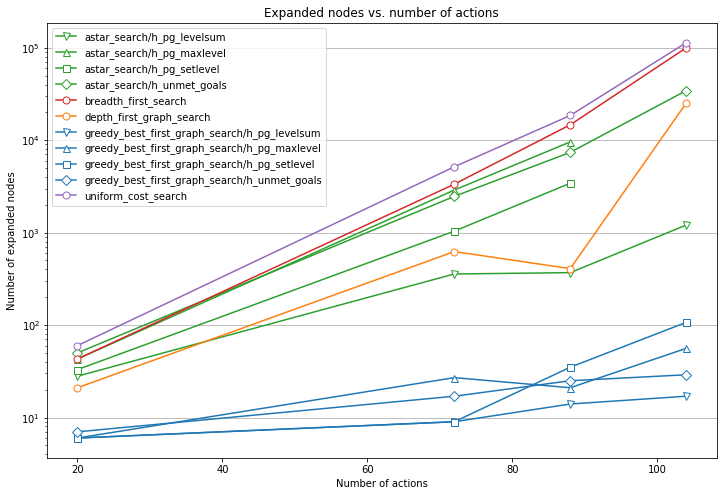

In [5]:
f1 = plot("expansions", 
          ylabel="Number of expanded nodes", 
          title="Expanded nodes vs. number of actions")
f1.savefig("expansions.png")

### Use a table or chart to analyze the search time against the number of actions in the domain

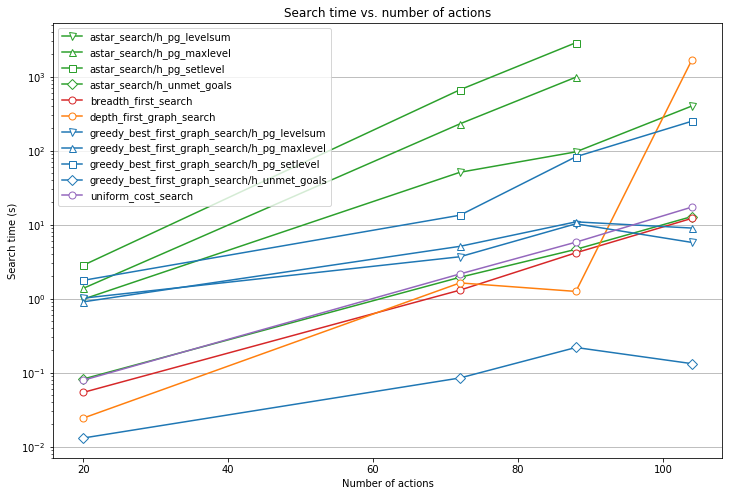

In [6]:
f2 = plot("time", 
          ylabel="Search time (s)", 
          title="Search time vs. number of actions")
f2.savefig("search_time.png")

### Use a table or chart to analyze the length of the plans returned by each algorithm on all search problems

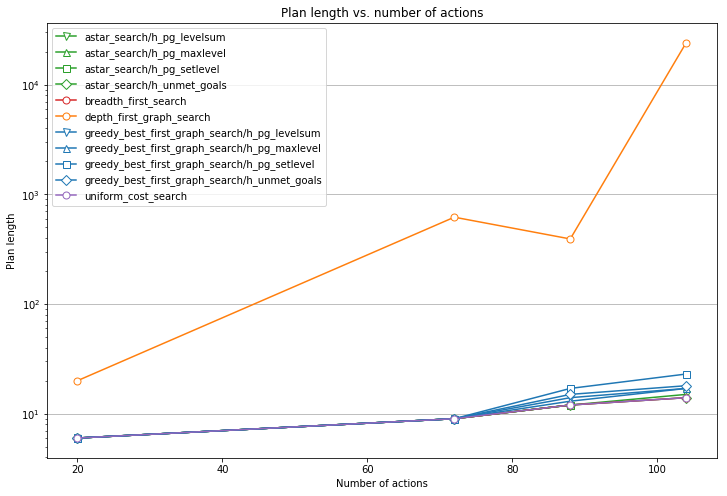

In [7]:
f3 = plot("plan_length", 
          ylabel="Plan length", 
          title="Plan length vs. number of actions")
f3.savefig("plan_length_1.png")

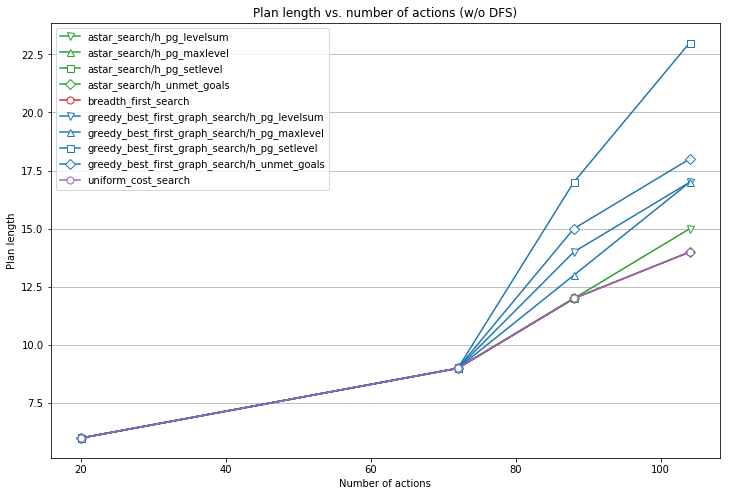

In [8]:
f4 = plot("plan_length", 
          ylabel="Plan length", 
          title="Plan length vs. number of actions (w/o DFS)",
          skip_algorithms=["depth_first_graph_search"],
          yscale='linear'
         )
f4.savefig("plan_length_2.png")

In [9]:
cols = " actions algorithm heuristic plan_length ".split()
df[cols].sort_values(['actions', 'plan_length'])

,actions,algorithm,heuristic,plan_length
0,20,breadth_first_search,,6
4,20,uniform_cost_search,,6
5,20,greedy_best_first_graph_search,h_unmet_goals,6
6,20,greedy_best_first_graph_search,h_pg_levelsum,6
7,20,greedy_best_first_graph_search,h_pg_maxlevel,6
8,20,greedy_best_first_graph_search,h_pg_setlevel,6
9,20,astar_search,h_unmet_goals,6
10,20,astar_search,h_pg_levelsum,6
1,20,astar_search,h_pg_maxlevel,6
2,20,astar_search,h_pg_setlevel,6


### Problem vs. number of actions

In [22]:
cols = "actions problem".split()
#print(df[cols].drop_duplicates().sort_values('problem').to_html(index=False))
df[cols].drop_duplicates().sort_values('problem')

,actions,problem
0,20,1
11,72,2
22,88,3
33,104,4


## Notes

In [23]:
cols = "actions algorithm heuristic plan_length time".split()
#print(df[cols].query("actions == 20").sort_values("time").to_html(index=False))
df[cols].query("actions == 20").sort_values("time").head()

,actions,algorithm,heuristic,plan_length,time
5,20,greedy_best_first_graph_search,h_unmet_goals,6,0.013098
3,20,depth_first_graph_search,,20,0.024324
0,20,breadth_first_search,,6,0.054103
4,20,uniform_cost_search,,6,0.079008
9,20,astar_search,h_unmet_goals,6,0.082072


Uninformed search methods have access only to the problem definition. The basic
algorithms are as follows:

- Breadth-first search expands the shallowest nodes first; it is complete, optimal
  for unit step costs, but has exponential space complexity.
- Uniform-cost search expands the node with lowest path cost, g(n), and is optimal
  for general step costs.
- Depth-first search expands the deepest unexpanded node first. It is neither com-
  plete nor optimal, but has linear space complexity. Depth-limited search adds a
  depth bound.

Informed search methods may have access to a heuristic function h(n) that estimates
the cost of a solution from n.

- The generic best-first search algorithm selects a node for expansion according to
  an evaluation function.
- Greedy best-first search expands nodes with minimal h(n). It is __not optimal__ but
  is often efficient.
- A∗ search expands nodes with minimal f(n) = g(n) + h(n). A∗ is __complete__ and
  __optimal__, provided that h(n) is admissible (for TREE-SEARCH ) or __consistent__ (for
  GRAPH-SEARCH ). __The space complexity of A∗ is still prohibitive__.
- RBFS (recursive best-first search) and SMA∗ (simplified memory-bounded A ∗ )
  are robust, optimal search algorithms that use limited amounts of memory; given
  enough time, they can solve problems that A∗ cannot solve because it runs out of
  memory.

A planning graph is polynomial in the size of the planning problem. For a planning
problem with $l$ literals and $a$ actions, each $S_i$ has no more than $l$ nodes and $l^2$ mutex links,
and each $A_i$ has no more than $a + l$ nodes (including the no-ops), $(a + l)^2$ mutex links, and
$2(al + l)$ precondition and effect links. Thus, an entire graph with $n$ levels has a size of
$O(n(a + l)^2)$. The time to build the graph has the same complexity.

* max-level: admisseble, but not necessarily accurate
* levelsum can be inadmissible but works well in practice for problems that are largely decomposable
* set-level: It is admissible, it dominates the max-level heuristic, and it works extremely well on tasks in which there is a good deal of interaction among subplans

class 1: < 0.1 s for 20 actions
- greedy best first graph search / h unmet goals
- breadth first (optimal)
- uniform cost
- astar / unmet goals -> is 

- depth first (hmm... plan length is not optimal)


### Which algorithm or algorithms would be most appropriate for planning in a very restricted domain (i.e., one that has only a few actions) and needs to operate in real time?

criteria: 
- space complexity does not matter
- optimality does not matter
- time is key 
- avoid the planning graph ???

choices:
- ...

### Which algorithm or algorithms would be most appropriate for planning in very large domains (e.g., planning delivery routes for all UPS drivers in the U.S. on a given day)

criteria:
- need low space complexity !!!
- time: not so important
- optimality matters???

chioces:
- greedy best first search
- depth first


### Which algorithm or algorithms would be most appropriate for planning problems where it is important to find only optimal plans?

criteria: 
- optimality

choices:
- breadth first
- uniform cost
- astar with admissible heuristics:
  - ...
  - ...

### Experiment with the planning algorithms

The `run_search.py` script allows you to choose any combination of eleven search algorithms (three uninformed and eight with heuristics) on four air cargo problems. The cargo problem instances have different numbers of airplanes, cargo items, and airports that increase the complexity of the domains.

- You should run **all** of the search algorithms on the first two problems and record the following information for each combination:
    - number of actions in the domain
    - number of new node expansions
    - time to complete the plan search

- Use the results from the first two problems to determine whether any of the uninformed search algorithms should be excluded for problems 3 and 4. You must run **at least** one uninformed search, two heuristics with greedy best first search, and two heuristics with A* on problems 3 and 4.


## Report Requirements

Your submission for review **must** include a report named "report.pdf" that includes all of the figures (charts or tables) and written responses to the questions below. You may plot multiple results for the same topic on the same chart or use multiple charts. (Hint: you may see more detail by using log space for one or more dimensions of these charts.)

- Use a table or chart to analyze the number of nodes expanded against number of actions in the domain
- Use a table or chart to analyze the search time against the number of actions in the domain
- Use a table or chart to analyze the length of the plans returned by each algorithm on all search problems

Use your results to answer the following questions:

- Which algorithm or algorithms would be most appropriate for planning in a very restricted domain (i.e., one that has only a few actions) and needs to operate in real time?

- Which algorithm or algorithms would be most appropriate for planning in very large domains (e.g., planning delivery routes for all UPS drivers in the U.S. on a given day)

- Which algorithm or algorithms would be most appropriate for planning problems where it is important to find only optimal plans?

## Evaluation

Your project will be reviewed by a Udacity reviewer against the project rubric [here](https://review.udacity.com/#!/rubrics/1800/view). Review this rubric thoroughly, and self-evaluate your project before submission. All criteria found in the rubric must meet specifications for you to pass.


## Submission

Before you can submit your project for review in the classroom, you must run the remote test suite & generate a zip archive of the required project files. Submit the archive in your classroom for review. (See notes on submissions below for more details.) From your terminal, run the command: (make sure to activate the aind conda environment if you're running the project in your local environment; workspace users do **not** need to activate an environment.)
```
$ udacity submit
```
The script will automatically create a zip archive of the required files (`my_planning_graph.py` and `report.pdf`) and submit your code to a remote server for testing. You can only submit a zip archive created by the PA script (even if you're only submitting a partial solution), and you **must submit the exact zip file created by the Project Assistant** in your classroom for review. The classroom verifies the zip file submitted against records on the Project Assistant system; any changes in the file will cause your submission to be rejected.

**NOTE:** Students who authenticate with Facebook or Google accounts _must_ follow the instructions on the FAQ page [here](https://project-assistant.udacity.com/faq) to obtain an authentication token. (The Workspace already includes instructions for obtaining and configuring your token.)


## (Optional) Project Enhancements

You will find in this project that even trivial planning problems become intractable for domain-independent planning. (The search space for planning problems grows exponentially with problem size.) However, this code can be used as a basis to explore automated planning more deeply by incorporating optimizations or additional planning algorithms (like GraphPlan) to create a more robust planner.

1. Static code optimizations
	- Several optimizations have been omitted for simplicity. For example, the `Expr` class used for symbolic representations of the actions and literals is _very_ slow (the time to do basic operations like negating an object can be 1000x slower than more optimal representations). And the inconsistent effects, interference, and negation mutexes are static for a given problem domain; they do not need to be checked each time a layer is added to the planning graph.

2. Optimize the planning graph implementaion (ref. section 6 [Planning graph as the basis for deriving heuristics
for plan synthesis by state space and CSP search](https://ac.els-cdn.com/S0004370201001588/1-s2.0-S0004370201001588-main.pdf?_tid=571411a9-859b-4a29-83c7-686d44673011&acdnat=1523663582_550f8fef02020c1c90bf6ef1caef3eaa))
    - One way to implement a much faster planning graph uses a bi-level structure to reduce construction time and memory consumption. The complete list of states and complete list of actions are known when the planning graph instance is created (they're static), and the set of static mutexes is also fixed. A single list can be used to track the first layer at which each literal or action enter the planning graph (they will remain in the graph in all future layers), and a single list can be used to track when mutexes first leave the graph (they will remain out of the graph in all future layers).

3. Use a different language
	- Python is slow. Using a faster language can deliver a few orders of magnitude faster performance, which can make non-trivial problem domains feasible. The planning graph is particularly inefficient, in part due to idiosyncrasies of Python with an implementation designed for _clarity_ rather than performance. The [Europa](https://github.com/nasa/europa) planner from NASA should be much faster.

4. Build your own problems
    - The air cargo domain problems implemented for you were chosen to represent various changes in complexity. There are many other problems that you could implement on your own. For example, the block world problem and spare tire problem in the AIMA textbook. You can also find examples online of planning domain problems. Implement one or more problems beyond the air cargo domain and see how your planner works in those domains.


### Additional Search Topics

- Regression search with GraphPlan (ref. [GraphPlan](https://github.com/aimacode/aima-pseudocode/blob/master/md/GraphPlan.md) in the AIMA pseudocode). Regression search can be very fast in some problem domains, but progression search has been more popular in recent years because it is more easily extended to real-world problems, for example to support resource constraints (like planning for battery recharging in mobile robots).

- Progression search with Monte Carlo Tree Search (e.g., ["Using Monte Carlo Tree Search to Solve Planning Problems in Transportation Domains"](https://link.springer.com/chapter/10.1007%2F978-3-642-45111-9_38))
